[*웹 로그 기반 조회수 예측*](https://dacon.io/competitions/official/236226/overview/description)
- Public: LightGBM 2.9331158308                           
- Private: Catboost 2.9100266576

0. Import
1. Load Data
2. 데이터 전처리
    - 결측값 대체
    - Label 인코딩 및 변수 제거
3. 모델링
    - Lasso
    - RandomForsetRegressor
    - CatboostRegressor
    - CatboostRegressor randomized_search
    - XGBRegressor
    - LightGBM
    - DecisionTreeRegressor
    - KNN
    - LGBM RandomizedSearchCV
    - LGBM GridSearchCV
    - ElasticNet


### Import

In [ ]:
import random
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from datetime import datetime

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed=42
seed_everything(seed) # Seed 고정

### Load Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/test.csv')

display(train.head(3))
display(test.head(3))

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_000000,USER_000000,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,SESSION_000001,USER_000001,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN


,sessionID,userID,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_252289,USER_206024,Chrome,Linux,desktop,1,75.0,698.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
1,SESSION_252290,USER_206025,Safari,iOS,tablet,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
2,SESSION_252291,USER_206026,Chrome,Windows,desktop,1,1.0,33.0,0,0.0,0.0,Asia,Southern Asia,India,youtube.com,referral,NaN,Category2_Path_0082


* sessionID : 세션 ID
* userID : 사용자 ID
* TARGET : 세션에서 발생한 총 조회수
* browser : 사용된 브라우저
* OS : 사용된 기기의 운영체제
* device : 사용된 기기
* new : 첫 방문 여부 (0: 첫 방문 아님, 1: 첫 방문)
* quality : 세션의 질 (거래 성사를 기준으로 측정된 값, 범위: 1~100)
* duration : 총 세션 시간 (단위: 초)
* bounced : 이탈 여부 (0: 이탈하지 않음, 1: 이탈함)
* transaction : 세션 내에서 발생의 거래의 수
* transaction_revenue : 총 거래 수익
* continent : 세션이 발생한 대륙
* subcontinent : 세션이 발생한 하위 대륙
* country : 세션이 발생한 국가
* traffic_source : 트래픽이 발생한 소스
* traffic_medium : 트래픽 소스의 매체
* keyword : 트래픽 소스의 키워드, 일반적으로 traffic_medium이 organic, cpc인 경우에 설정
* referral_path : traffic_medium이 referral인 경우 설정되는 경로

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sessionID            252289 non-null  object 
 1   userID               252289 non-null  object 
 2   TARGET               252289 non-null  float64
 3   browser              252289 non-null  object 
 4   OS                   252289 non-null  object 
 5   device               252289 non-null  object 
 6   new                  252289 non-null  int64  
 7   quality              252289 non-null  float64
 8   duration             252289 non-null  float64
 9   bounced              252289 non-null  int64  
 10  transaction          252289 non-null  float64
 11  transaction_revenue  252289 non-null  float64
 12  continent            252289 non-null  object 
 13  subcontinent         252289 non-null  object 
 14  country              252289 non-null  object 
 15  traffic_source   

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79786 entries, 0 to 79785
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   browser              79786 non-null  int64  
 1   OS                   79786 non-null  int64  
 2   device               79786 non-null  int64  
 3   new                  79786 non-null  int64  
 4   quality              79786 non-null  float64
 5   duration             79786 non-null  float64
 6   bounced              79786 non-null  int64  
 7   transaction          79786 non-null  float64
 8   transaction_revenue  79786 non-null  float64
 9   continent            79786 non-null  int64  
 10  subcontinent         79786 non-null  int64  
 11  country              79786 non-null  int64  
 12  traffic_source       79786 non-null  int64  
 13  traffic_medium       79786 non-null  int64  
 14  keyword              36716 non-null  object 
 15  referral_path        25895 non-null 

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,252289.0,3.592626,5.509465e+00,1.0,1.0,2.0,4.0,3.860000e+02
new,252289.0,0.751955,4.318789e-01,0.0,1.0,1.0,1.0,1.000000e+00
quality,252289.0,3.816805,1.109103e+01,1.0,1.0,1.0,1.0,9.800000e+01
duration,252289.0,113.104253,3.308760e+02,0.0,0.0,3.0,71.0,1.118600e+04
bounced,252289.0,0.493672,4.999609e-01,0.0,0.0,0.0,1.0,1.000000e+00
transaction,252289.0,0.009033,1.009376e-01,0.0,0.0,0.0,0.0,1.200000e+01
transaction_revenue,252289.0,906124.829224,2.127689e+07,0.0,0.0,0.0,0.0,3.325712e+09


In [ ]:
train.describe(include="object").T

,count,unique,top,freq
sessionID,252289,252289,SESSION_000000,1
userID,252289,206024,USER_002675,78
browser,252289,70,Chrome,174395
OS,252289,21,Windows,88119
device,252289,3,desktop,167133
continent,252289,6,Americas,126506
subcontinent,252289,23,Northern America,111945
country,252289,205,United States,104201
traffic_source,252289,168,google,116007
traffic_medium,252289,7,organic,107370


In [ ]:
train = train.drop(columns=['sessionID','userID'],axis=1)
test = test.drop(columns=['sessionID','userID'],axis=1)

In [ ]:
train[train.duplicated()]

,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
37,1.0,Safari,iOS,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
62,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
99,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
109,1.0,Safari (in-app),iOS,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,cpc,Category9,NaN
121,1.0,Safari (in-app),iOS,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,cpc,Category9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252284,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Europe,Northern Europe,United Kingdom,youtube.com,referral,NaN,Category5_Path_0032
252285,1.0,Chrome,Macintosh,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
252286,5.0,Chrome,Macintosh,desktop,0,2.0,69.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252287,1.0,Android Webview,Android,mobile,1,1.0,28.0,0,0.0,0.0,Africa,Northern Africa,Egypt,youtube.com,referral,NaN,Category2_Path_0018


In [ ]:
test[test.duplicated()]

,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
29,Safari,iOS,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
42,Safari,iOS,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
59,Safari,iOS,tablet,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
60,Safari,iOS,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
61,Safari,iOS,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79773,Chrome,Windows,desktop,1,1.0,0.0,1,0.0,0.0,Americas,South America,Peru,l.facebook.com,referral,NaN,Category6_Path_0769
79775,Safari (in-app),iOS,mobile,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,cpc,Category11,NaN
79782,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
79784,Safari,iOS,mobile,1,1.0,135.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN


### 시각화

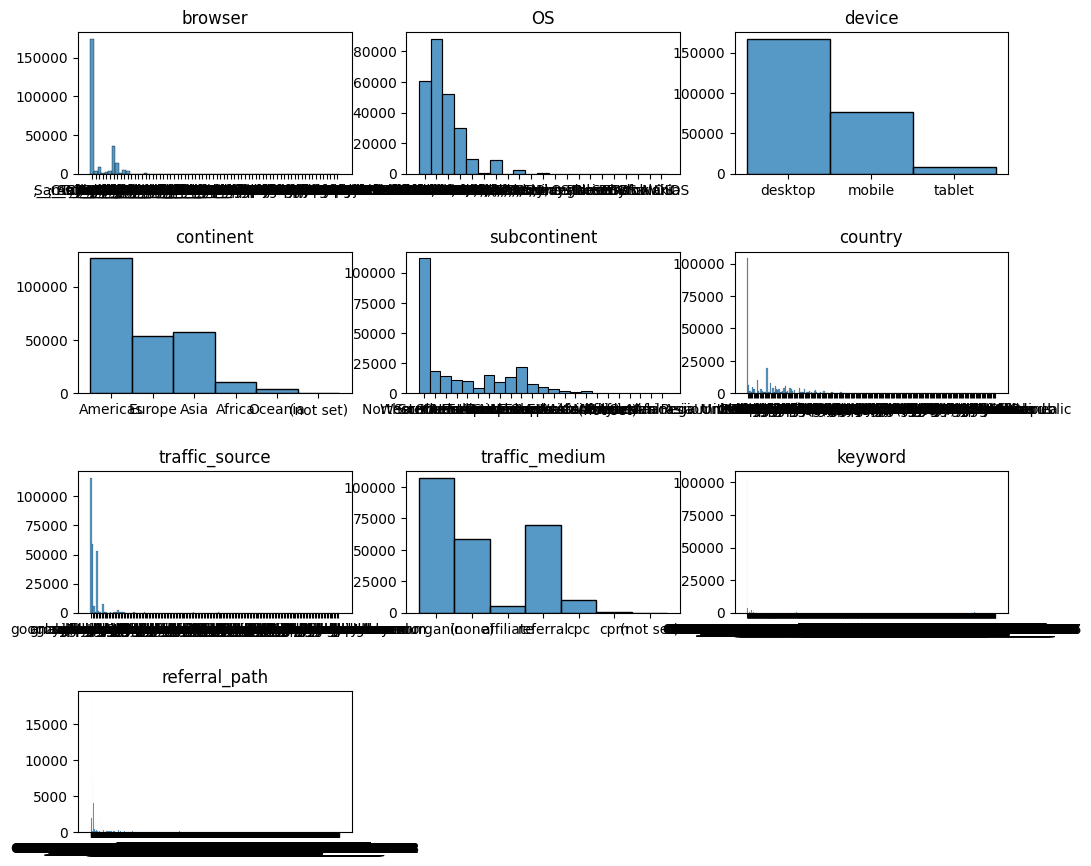

In [ ]:
col = ['browser', 'OS', 'device', 'continent', 'subcontinent', 'country', 'traffic_source', 'traffic_medium', 'keyword', 'referral_path']

plt.figure(figsize=(12, 10))

for i in range(len(col)):
    plt.subplot(4, 3, i+1)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.55)
    plt.title(col[i])
    sns.histplot(train[col[i]])
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

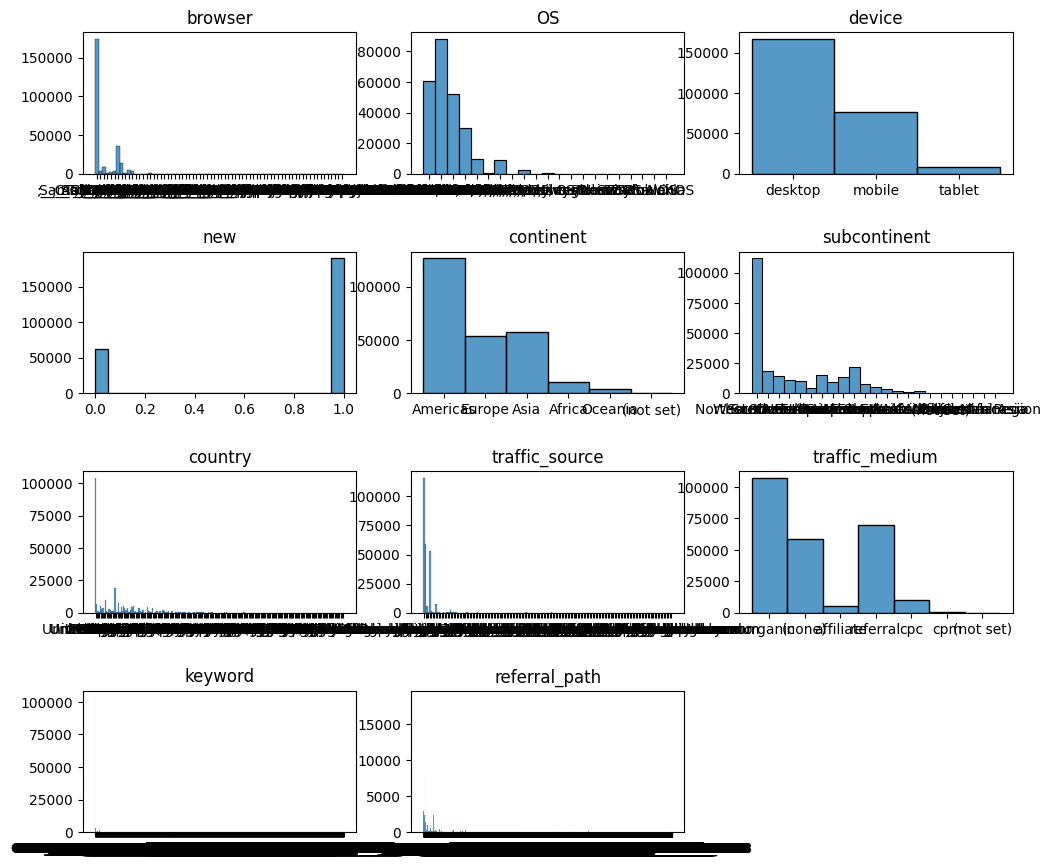

In [ ]:
col = ['browser', 'OS', 'device', 'new', 'bounced', 'continent', 'subcontinent', 'country', 'traffic_source', 'traffic_medium', 'keyword', 'referral_path']

plt.figure(figsize=(12, 10))

for i in range(len(col)):
    plt.subplot(4, 3, i+1)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.55)
    plt.title(col[i])
    sns.histplot(train[col[i]])
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

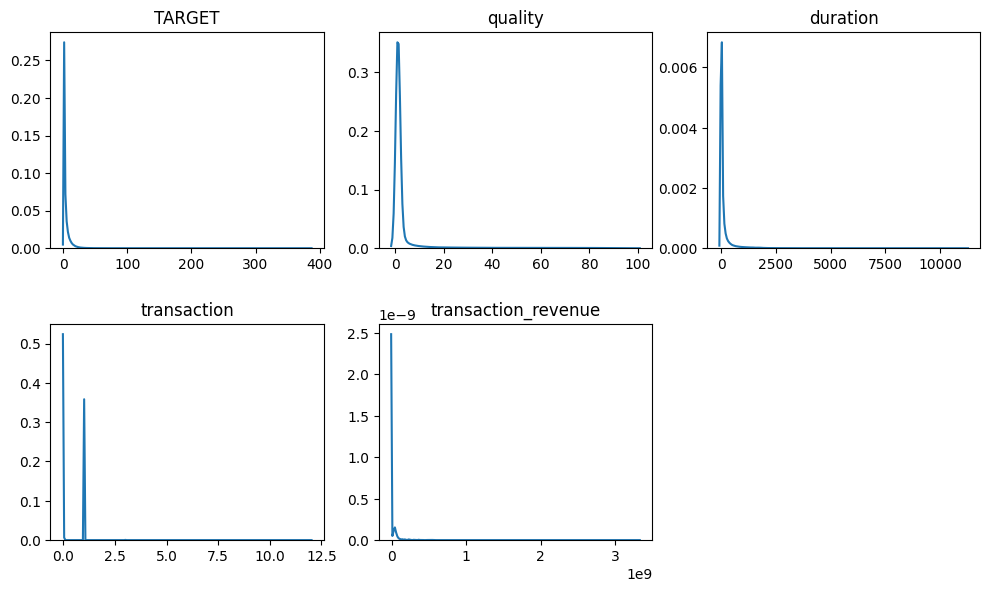

In [ ]:
col = ['TARGET', 'quality', 'duration', 'transaction', 'transaction_revenue']

plt.figure(figsize=(12, 10))

for i in range(len(col)):
    plt.subplot(3, 3, i+1, )
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
    plt.title(col[i])
    sns.kdeplot(train[col[i]])
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

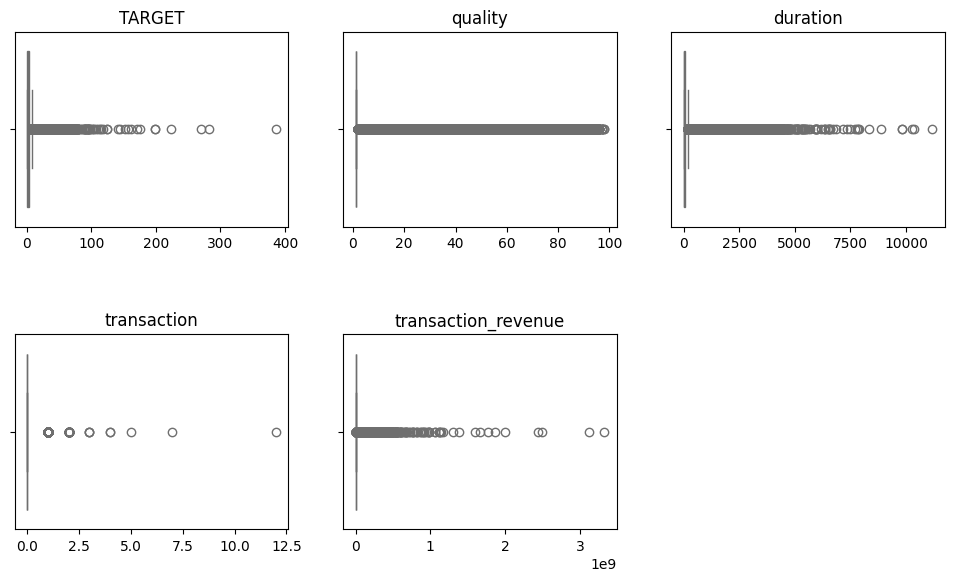

In [ ]:
col = ['TARGET', 'quality', 'duration', 'transaction', 'transaction_revenue']

plt.figure(figsize=(12, 10))

for i in range(len(col)):
    plt.subplot(3, 3, i+1)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.55)
    plt.title(col[i])
    sns.boxplot(x=train[col[i]], color='skyblue')
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

### 결측치 처리

In [ ]:
train.isnull().sum()

TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                137675
referral_path          161107
dtype: int64

In [ ]:
train['transaction'].value_counts()

0.0     250081
1.0       2162
2.0         38
3.0          3
4.0          2
5.0          1
7.0          1
12.0         1
Name: transaction, dtype: int64

In [ ]:
train['transaction_revenue'].value_counts()

0.0            250087
43405120.0         31
46237120.0         27
40573120.0         26
42461120.0         25
                ...  
216478080.0         1
165181120.0         1
90350240.0          1
68770400.0          1
461559360.0         1
Name: transaction_revenue, Length: 1218, dtype: int64

In [ ]:
train[train['transaction_revenue'] == 0]

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_000000,USER_000000,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,SESSION_000001,USER_000001,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,SESSION_000003,USER_000003,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
4,SESSION_000004,USER_000004,1.0,Chrome,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,groups.google.com,referral,NaN,Category6_Path_0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252284,SESSION_252284,USER_206021,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Europe,Northern Europe,United Kingdom,youtube.com,referral,NaN,Category5_Path_0032
252285,SESSION_252285,USER_206022,1.0,Chrome,Macintosh,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
252286,SESSION_252286,USER_164240,5.0,Chrome,Macintosh,desktop,0,2.0,69.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252287,SESSION_252287,USER_206023,1.0,Android Webview,Android,mobile,1,1.0,28.0,0,0.0,0.0,Africa,Northern Africa,Egypt,youtube.com,referral,NaN,Category2_Path_0018


In [ ]:
train[train['referral_path'].isnull() & train['keyword'].isnull()]

,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
2,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
10,6.0,Chrome,Windows,desktop,1,1.0,28.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
13,1.0,Opera,Linux,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
15,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Europe,Western Europe,Germany,(direct),(none),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252271,6.0,Chrome,Macintosh,desktop,1,3.0,203.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,NaN,NaN
252272,9.0,Chrome,Macintosh,desktop,1,19.0,210.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
252276,12.0,Chrome,Macintosh,desktop,1,18.0,129.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
252277,2.0,Chrome,iOS,mobile,1,1.0,37.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN


In [ ]:
train['referral_path'].unique()

array([nan, 'Category6_Path_0000', 'Category7_Path_0001', ...,
       'Category9_Path_1574', 'Category2_Path_1575',
       'Category6_Path_1576'], dtype=object)

In [ ]:
test['keyword'].value_counts()

Category8                34598
Category11                 525
Category10                 340
Category9                  329
Category12                 320
                         ...  
Category3_Keyword_618        1
Category2_Keyword_462        1
Category2_Keyword_628        1
Category2_Keyword_678        1
Category2_Keyword_675        1
Name: keyword, Length: 211, dtype: int64

In [ ]:
new_train = train.copy()
new_test = test.copy()

In [ ]:
new_train['keyword'].fillna(train['keyword'].mode()[0], inplace=True)
new_train['referral_path'].fillna('no_category', inplace=True)
# new_train = new_train.drop('referral_path', axis=1)
# traffic_medium이 referral인 경우 설정되는 경로이므로 최빈값으로 대체 X

In [ ]:
new_test['keyword'].fillna(train['keyword'].mode()[0], inplace=True)
new_test['referral_path'].fillna('no_category', inplace=True)
# new_test = new_test.drop('referral_path', axis=1)

In [ ]:
new_train.head()

,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword
0,17.0,27,7,0,0,45.0,839.0,0,0.0,0.0,2,12,196,46,5,621
1,3.0,27,17,0,1,1.0,39.0,0,0.0,0.0,4,22,67,46,5,621
2,1.0,51,1,1,1,1.0,0.0,1,0.0,0.0,3,16,115,0,0,621
3,1.0,27,7,0,1,1.0,0.0,1,0.0,0.0,2,12,196,1,2,621
4,1.0,27,20,1,0,1.0,0.0,1,0.0,0.0,2,12,196,87,6,621


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


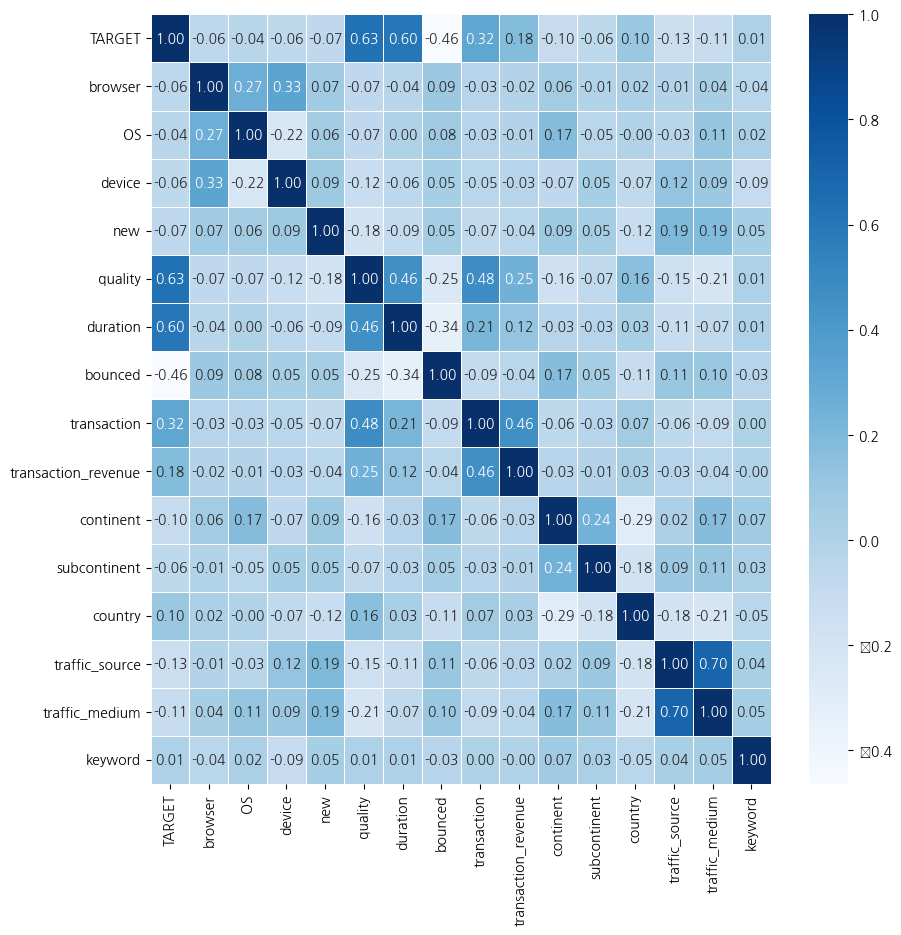

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data = new_train.corr(), annot=True, cmap='Blues', fmt = '.2f', linewidths=.5)

### Label 인코딩 및 변수 제거

In [ ]:
categorical_features = list(new_train.dtypes[new_train.dtypes == "object"].index)

for i in categorical_features:
    count = new_train[i].nunique()
    print(f"{i}: {count}")

browser: 70
OS: 21
device: 3
continent: 6
subcontinent: 23
country: 205
traffic_source: 168
traffic_medium: 7
keyword: 623


In [ ]:
# new_train = new_train.drop(columns=['sessionID','userID'],axis=1)
# new_test = new_test.drop(columns=['sessionID','userID'],axis=1)

In [ ]:
encoding_target = list(new_test.dtypes[new_test.dtypes == "object"].index)

for i in encoding_target:
    le = LabelEncoder()
    le.fit(new_train[i])
    new_train[i] = le.transform(new_train[i])

    for case in np.unique(new_test[i]):
        if case not in le.classes_:
            le.classes_ = np.append(le.classes_, case)

    new_test[i] = le.transform(new_test[i])

In [ ]:
new_train.to_csv('new_train.csv', index=False)
new_test.to_csv('new_test.csv', index=False)

In [ ]:
train_x = new_train.drop(columns=['TARGET'])
train_y = new_train['TARGET']

test_x = new_test

### Lasso  *(3.8747265889 / 3.7669138432)*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1).fit(train_x,train_y)
preds = lasso.predict(test_x)

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission['TARGET'] = preds
submission

,sessionID,TARGET
0,SESSION_252289,22.826651
1,SESSION_252290,1.362503
2,SESSION_252291,3.512813
3,SESSION_252292,4.196410
4,SESSION_252293,5.924896
...,...,...
79781,SESSION_332070,1.424369
79782,SESSION_332071,1.439631
79783,SESSION_332072,4.137534
79784,SESSION_332073,4.521409


In [ ]:
submission.to_csv('./baseline_submission.csv', index=False)

### RandomForsetRegressor *(3.1216876766 / 2.9957249987)*

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(train_x, train_y)

RandomForestRegressor(random_state=42)

In [ ]:
preds = rf_model.predict(test_x)

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission['TARGET'] = preds
submission

,sessionID,TARGET
0,SESSION_252289,25.030000
1,SESSION_252290,1.000000
2,SESSION_252291,1.481493
3,SESSION_252292,3.488954
4,SESSION_252293,9.596667
...,...,...
79781,SESSION_332070,1.000000
79782,SESSION_332071,1.000000
79783,SESSION_332072,2.906667
79784,SESSION_332073,4.413333


In [ ]:
submission.to_csv('./randomforest_submission.csv', index=False)

### CatboostRegressor *(2.954916694 / 2.9100266576)*

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.5 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_state=42)
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=50)

0:	learn: 5.2059222	test: 5.0378748	best: 5.0378748 (0)	total: 161ms	remaining: 2m 40s
100:	learn: 2.7233545	test: 2.5787061	best: 2.5787061 (100)	total: 10.4s	remaining: 1m 32s
200:	learn: 2.5838556	test: 2.5309317	best: 2.5278434 (183)	total: 17.1s	remaining: 1m 8s
300:	learn: 2.4691890	test: 2.5264843	best: 2.5226585 (274)	total: 25.6s	remaining: 59.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.518194259
bestIteration = 345

Shrink model to first 346 iterations.


In [ ]:
predictions = model.predict(test_x)

submission = pd.read_csv('./sample_submission.csv')
submission['TARGET'] = predictions
submission.to_csv('./catboost_submission.csv', index=False)

y_val_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print("Validation Set RMSE:", rmse)

Validation Set RMSE: 2.5181942593898583


In [ ]:
new_train_x = train_x.drop(columns=['keyword'],axis=1)
new_test_x = test_x.drop(columns=['keyword'],axis=1)

X_train, X_val, y_train, y_val = train_test_split(new_train_x, train_y, test_size=0.2, random_state=42)

model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_state=42)
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=50)

predictions = model.predict(new_test_x)

submission = pd.read_csv('./sample_submission.csv')
submission['TARGET'] = predictions
submission.to_csv('./catboost_submission2.csv', index=False)

y_val_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print("Validation Set RMSE:", rmse)

0:	learn: 5.2114107	test: 5.0436042	best: 5.0436042 (0)	total: 64.5ms	remaining: 1m 4s
100:	learn: 2.7309581	test: 2.5891838	best: 2.5891838 (100)	total: 6.24s	remaining: 55.5s
200:	learn: 2.5515912	test: 2.5399883	best: 2.5399883 (200)	total: 9s	remaining: 35.8s
300:	learn: 2.4422446	test: 2.5276899	best: 2.5266369 (297)	total: 11.8s	remaining: 27.4s
400:	learn: 2.3747473	test: 2.5189621	best: 2.5189621 (400)	total: 14.5s	remaining: 21.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.518810148
bestIteration = 402

Shrink model to first 403 iterations.
Validation Set RMSE: 2.518810147889916


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_train = train.drop(['referral_path', 'keyword'], axis=1)
scaler_test = test.drop(['referral_path', 'keyword'], axis=1)

features = ['quality', 'duration', 'transaction', 'transaction_revenue']

scaler = MinMaxScaler()
scaler_train[features] = scaler.fit_transform(scaler_train[features])
scaler_test[features] = scaler.transform(scaler_test[features])

In [ ]:
scaler_train = scaler_train[scaler_train['bounced'] == 0]

In [ ]:
scaler_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127741 entries, 0 to 252288
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TARGET               127741 non-null  float64
 1   browser              127741 non-null  object 
 2   OS                   127741 non-null  object 
 3   device               127741 non-null  object 
 4   new                  127741 non-null  int64  
 5   quality              127741 non-null  float64
 6   duration             127741 non-null  float64
 7   bounced              127741 non-null  int64  
 8   transaction          127741 non-null  float64
 9   transaction_revenue  127741 non-null  float64
 10  continent            127741 non-null  object 
 11  subcontinent         127741 non-null  object 
 12  country              127741 non-null  object 
 13  traffic_source       127741 non-null  object 
 14  traffic_medium       127741 non-null  object 
dtypes: float64(5), in

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ["browser", "OS", "device", "continent", "subcontinent", "country", "traffic_source", "traffic_medium"]

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train[i])
    scaler_train[i]=le.transform(scaler_train[i])

    for case in np.unique(scaler_test[i]):
        if case not in le.classes_:
            le.classes_ = np.append(le.classes_, case)
    scaler_test[i]=le.transform(scaler_test[i])

In [ ]:
X = scaler_train.drop(['TARGET'], axis=1)
y = scaler_train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_state=42)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=50)

predictions = cat_model.predict(scaler_test)

y_val_pred = cat_model.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print("Validation Set RMSE:", rmse)

0:	learn: 6.4098144	test: 6.8764279	best: 6.8764279 (0)	total: 20.4ms	remaining: 20.4s
100:	learn: 3.6477792	test: 4.3925047	best: 4.3922242 (98)	total: 2.98s	remaining: 26.5s
200:	learn: 3.4480463	test: 4.3293277	best: 4.3284622 (198)	total: 4.66s	remaining: 18.5s
300:	learn: 3.3318325	test: 4.3158995	best: 4.3158995 (300)	total: 6.75s	remaining: 15.7s
400:	learn: 3.2440031	test: 4.3037408	best: 4.3027596 (394)	total: 9.6s	remaining: 14.3s
500:	learn: 3.1773881	test: 4.2982330	best: 4.2972027 (488)	total: 11.1s	remaining: 11.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.294834884
bestIteration = 539

Shrink model to first 540 iterations.
Validation Set RMSE: 4.294834884234053


In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission['TARGET'] = predictions
submission.loc[scaler_test['bounced'] == 1, 'TARGET'] = 1
submission.loc[submission['TARGET'] < 1, 'TARGET'] = 1
submission.to_csv('./catboost_submission3.csv', index=False)
submission

,sessionID,TARGET
0,SESSION_252289,53.128122
1,SESSION_252290,1.000000
2,SESSION_252291,4.646003
3,SESSION_252292,5.905772
4,SESSION_252293,14.064054
...,...,...
79781,SESSION_332070,1.000000
79782,SESSION_332071,1.000000
79783,SESSION_332072,4.405055
79784,SESSION_332073,7.055916


randomized_search (3.207986975 / 3.1055021562)

In [ ]:
import catboost
from scipy.stats import randint
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

model_cat = catboost.CatBoostRegressor(eval_metric='R2')

param_grid = {
    'n_estimators': randint(100, 300),
    'depth': randint(1, 5),
    'learning_rate': loguniform(1e-3, 0.1),
    'min_child_samples': randint(10, 40),
    'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise']
}

model_cat.randomized_search(param_grid, X_train, y_train, cv=3, n_iter=10, verbose=1)
model_cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=10, early_stopping_rounds=50)

0:	learn: -0.2785032	test: -0.3102377	best: -0.3102377 (0)	total: 115ms	remaining: 33.5s
1:	learn: -0.1658147	test: -0.1862040	best: -0.1862040 (1)	total: 143ms	remaining: 20.7s
2:	learn: -0.0702271	test: -0.0809735	best: -0.0809735 (2)	total: 168ms	remaining: 16.2s
3:	learn: 0.0109313	test: 0.0083605	best: 0.0083605 (3)	total: 196ms	remaining: 14.1s
4:	learn: 0.0799876	test: 0.0846123	best: 0.0846123 (4)	total: 239ms	remaining: 13.7s
5:	learn: 0.1396593	test: 0.1503183	best: 0.1503183 (5)	total: 264ms	remaining: 12.6s
6:	learn: 0.1906119	test: 0.2063752	best: 0.2063752 (6)	total: 329ms	remaining: 13.4s
7:	learn: 0.2348533	test: 0.2552265	best: 0.2552265 (7)	total: 369ms	remaining: 13.1s
8:	learn: 0.2733163	test: 0.2975013	best: 0.2975013 (8)	total: 399ms	remaining: 12.6s
9:	learn: 0.3071170	test: 0.3347329	best: 0.3347329 (9)	total: 424ms	remaining: 12s
10:	learn: 0.3362463	test: 0.3667412	best: 0.3667412 (10)	total: 465ms	remaining: 11.9s
11:	learn: 0.3615696	test: 0.3947005	best: 0.

In [ ]:
predictions = model_cat.predict(test_x)

y_val_pred = model_cat.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print("Validation Set RMSE:", rmse)

Validation Set RMSE: 2.733154186071405


In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission['TARGET'] = predictions
submission.loc[test_x['bounced'] == 1, 'TARGET'] = 1
submission.loc[submission['TARGET'] < 1, 'TARGET'] = 1
submission.to_csv('./catboost_submission4.csv', index=False)
submission

,sessionID,TARGET
0,SESSION_252289,22.100540
1,SESSION_252290,1.000000
2,SESSION_252291,2.971643
3,SESSION_252292,4.077745
4,SESSION_252293,10.827515
...,...,...
79781,SESSION_332070,1.000000
79782,SESSION_332071,1.000000
79783,SESSION_332072,2.550812
79784,SESSION_332073,4.746630


In [ ]:
cat_train = pd.read_csv('train.csv')
cat_test = pd.read_csv('test.csv')

In [ ]:
categorical_features = [
"browser",
"OS",
"device",
"continent",
"subcontinent",
"country",
"traffic_source",
"traffic_medium",
]

for i in categorical_features:
    cat_train[i] = train[i].astype('category')
    cat_test[i] = test[i].astype('category')

In [ ]:
from catboost import CatBoostRegressor, Pool

x_train = cat_train.drop(['TARGET', 'sessionID','userID', 'keyword', 'referral_path'], axis=1)
x_test = cat_test.drop(['sessionID','userID', 'keyword', 'referral_path'], axis=1)
y_train = cat_train['TARGET']
train_pool = Pool(data=x_train, label=y_train, cat_features=categorical_features)

In [ ]:
clf = CatBoostRegressor(random_state=seed, verbose=False)
clf.fit(train_pool)

In [ ]:
test_pool = Pool(data=x_test, cat_features=categorical_features)
pred = clf.predict(test_pool)
pred = [0 if i < 0 else i for i in pred]
pred

In [ ]:
df_submit = pd.read_csv('sample_submission.csv')
df_submit['TARGET'] = pred
df_submit.to_csv("catboost_submission5.csv", index=False)

### XGBRegressor *(3.0311250253 / 2.9908763111)*

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

train_df = pd.read_csv('new_train.csv')
test_df = pd.read_csv('new_test.csv')

X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 6.778212139098268


In [ ]:
pred = model.predict(test_df)
pred = [0 if i < 0 else i for i in pred]

df_submit = pd.read_csv('sample_submission.csv')
df_submit['TARGET'] = pred
df_submit.to_csv("XGB_submission.csv", index=False)

### LightGBM (2.9331158308 / 2.9387104123)

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9
}

model = lgb.train(params, train_data, num_boost_round=100)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 201831, number of used features: 15
[LightGBM] [Info] Start training from score 3.593254
Mean Squared Error: 6.631108798555397


In [ ]:
pred = model.predict(test_df)
pred = [0 if i < 0 else i for i in pred]

df_submit = pd.read_csv('sample_submission.csv')
df_submit['TARGET'] = pred
df_submit.to_csv("LGBM_submission.csv", index=False)

RandomizedSearchCV (2.9331158308 / 2.9387104123)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import randint as sp_randint

param_dist = {
    'num_leaves': sp_randint(20, 50),
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': sp_randint(100, 500),
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

lgb_model = lgb.LGBMRegressor()

random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                   verbose=1, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score (Negative MSE):", random_search.best_score_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 201831, number of used features: 15
[LightGBM] [Info] Start training from score 3.593254
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 230, 'num_leaves': 24, 'subsample': 1.0}
Best Score (Negative MSE): -8.09806875209895
Mean Squared Error on Test Set: 6.604261174488008


In [ ]:
pred = best_model.predict(test_df)
pred = [0 if i < 0 else i for i in pred]

df_submit = pd.read_csv('sample_submission.csv')
df_submit['TARGET'] = pred
df_submit.to_csv("LGBM_submission2.csv", index=False)

GridSearchCV (2.956416606 / 2.9294263258)

In [ ]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('new_train.csv')
test_df = pd.read_csv('new_test.csv')

X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

lgb_model = lgb.LGBMRegressor()

grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)


In [ ]:
pred = best_model.predict(test_df)
pred = [0 if i < 0 else i for i in pred]

df_submit = pd.read_csv('sample_submission.csv')
df_submit['TARGET'] = pred
df_submit.to_csv("LGBM_submission3.csv", index=False)

### DecisionTreeRegressor *(3.6472174059 / 3.3399988185)*

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

train_df = pd.read_csv('new_train.csv')
test_df = pd.read_csv('new_test.csv')

X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train, y_train)
s
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 9.257738706880833


In [ ]:
pred = model.predict(test_df)
pred = [0 if i < 0 else i for i in pred]

df_submit = pd.read_csv('sample_submission.csv')
df_submit['TARGET'] = pred
df_submit.to_csv("DT_submission.csv", index=False)

### KNN *(3.8725869931 / 3.7858841317)*

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 12.253056403345358


In [ ]:
pred = model.predict(test_df)
pred = [0 if i < 0 else i for i in pred]

df_submit = pd.read_csv('sample_submission.csv')
df_submit['TARGET'] = pred
df_submit.to_csv("KNN_submission.csv", index=False)

### ElasticNet *(4.1234283019 / 4.0026859272)*

In [ ]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('new_train.csv')
test_df = pd.read_csv('new_test.csv')

X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

elasticnet = ElasticNet()

parameters = {"max_iter": [1, 5, 10],
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            "l1_ratio": np.arange(0.0, 1.0, 0.1)}

elasticnet_reg = RandomizedSearchCV(elasticnet, parameters, scoring='r2',cv=5)
elasticnet_reg.fit(X, y)
print(elasticnet_reg.best_params_)
print(elasticnet_reg.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.414e+06, tolerance: 6.053e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e+06, tolerance: 6.125e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

{'max_iter': 1, 'l1_ratio': 0.0, 'alpha': 0.01}
0.517930062573974


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e+06, tolerance: 7.658e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [ ]:
pred = elasticnet_reg.predict(test_df)
pred = [0 if i < 0 else i for i in pred]

df_submit = pd.read_csv('sample_submission.csv')
df_submit['TARGET'] = pred
df_submit.to_csv("ElasticNet_submission.csv", index=False)

### d

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))

svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
print("SVR Root Mean Squared Error:", rmse_svr)

SVR Root Mean Squared Error: 3.0096836170824726


In [ ]:
pred = svr.predict(test_df)
pred = [i[0] if isinstance(i, list) else i for i in pred]
pred = [0 if i < 0 else i for i in pred]

df_submit = pd.read_csv('sample_submission.csv')
df_submit['TARGET'] = pred
df_submit.to_csv("SVR_submission.csv", index=False)